In [1]:
import functions as fct
import re
import warnings
import numpy as np
import pandas as pd

# Visu
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()

# preprocessing sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

warnings.simplefilter(action='ignore', category=FutureWarning)



  # Chargement des données

In [2]:
application_train = pd.read_csv('../01_DATA/application_train.csv')
POS_CASH_balance = pd.read_csv('../01_DATA/POS_CASH_balance.csv')
bureau_balance = pd.read_csv('../01_DATA/bureau_balance.csv')
previous_application = pd.read_csv('../01_DATA/previous_application.csv')
installments_payments = pd.read_csv('../01_DATA/installments_payments.csv')
credit_card_balance = pd.read_csv('../01_DATA/credit_card_balance.csv')
bureau = pd.read_csv('../01_DATA/bureau.csv')



In [3]:
liste_fichiers = [application_train, POS_CASH_balance, bureau_balance,
                  previous_application, installments_payments, credit_card_balance,
                  bureau]
liste_noms_fichiers = ['application_train', 'POS_CASH_balance', 'bureau_balance',
                       'previous_application', 'installments_payments', 'credit_card_balance',
                       'bureau']

In [4]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# attribution nom à chaque fichier pour pouvoir les parcourir ensuite et retrait 
# première colonne 'unnamed:0'
for nom, file in zip(liste_noms_fichiers, liste_fichiers):
    file.name = nom
    # file.drop('Unnamed: 0', axis=1, inplace=True)

# Enregistrement target et identifiant des clients à part
target = application_train["TARGET"]
target.index = application_train.SK_ID_CURR

client_ID = application_train["SK_ID_CURR"]

In [7]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


 # Nettoyage et création de features

In [8]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


 ## Application_train

In [9]:
# CODE_GENDER : retrait des lignes avec XNA
print(application_train.shape)
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']
print(application_train.shape)


(307511, 122)
(307507, 122)


In [10]:
# anomalie sur la variable Days_employed
masque = (application_train.DAYS_EMPLOYED == 365243)
# creation d'une colonne pour stocker l'info anomalie / non  anomalie
application_train['DAYS_EMPLOYED_ANOM'] = masque

# remplacement des valeurs anormales par np.NaN
application_train.DAYS_EMPLOYED.replace({365243: np.nan}, inplace=True)

C:\Users\Helene\AppData\Local\Temp/ipykernel_41788/754208766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_train['DAYS_EMPLOYED_ANOM'] = masque
c:\Users\Helene\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [11]:
# Feature engineering (pourcentages)
application_train['DAYS_EMPLOYED_PERC'] = application_train['DAYS_EMPLOYED'] / \
    application_train['DAYS_BIRTH']
application_train['INCOME_CREDIT_PERC'] = application_train['AMT_INCOME_TOTAL'] / \
    application_train['AMT_CREDIT']
application_train['INCOME_PER_PERSON'] = application_train['AMT_INCOME_TOTAL'] / \
    application_train['CNT_FAM_MEMBERS']
application_train['ANNUITY_INCOME_PERC'] = application_train['AMT_ANNUITY'] / \
    application_train['AMT_INCOME_TOTAL']
application_train['PAYMENT_RATE'] = application_train['AMT_ANNUITY'] / \
    application_train['AMT_CREDIT']


C:\Users\Helene\AppData\Local\Temp/ipykernel_41788/642283841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_train['DAYS_EMPLOYED_PERC'] = application_train['DAYS_EMPLOYED'] / \
C:\Users\Helene\AppData\Local\Temp/ipykernel_41788/642283841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_train['INCOME_CREDIT_PERC'] = application_train['AMT_INCOME_TOTAL'] / \
C:\Users\Helene\AppData\Local\Temp/ipykernel_41788/642283841.py:6: SettingWithCopyWarning: 
A value is trying to be set o

<AxesSubplot:>

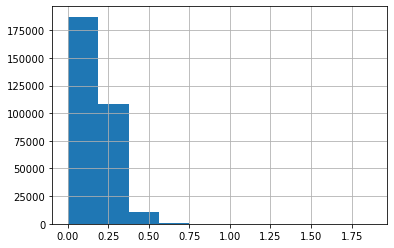

In [12]:
application_train.ANNUITY_INCOME_PERC.hist()

<AxesSubplot:>

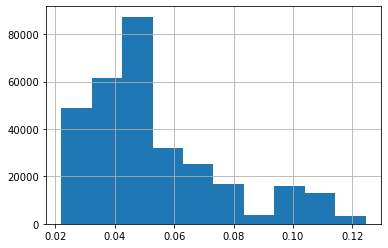

In [13]:
application_train['PAYMENT_RATE'].hist()

 ## Bureau_balance & bureau

In [14]:
nan_as_category = True
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
bureau_balance, bureau_balance_cat = one_hot_encoder(
    bureau_balance, nan_as_category)
# print(len(cat_liste))
bureau.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 40 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   SK_ID_CURR                                                int64  
 1   SK_ID_BUREAU                                              int64  
 2   DAYS_CREDIT                                               int64  
 3   CREDIT_DAY_OVERDUE                                        int64  
 4   DAYS_CREDIT_ENDDATE                                       float64
 5   DAYS_ENDDATE_FACT                                         float64
 6   AMT_CREDIT_MAX_OVERDUE                                    float64
 7   CNT_CREDIT_PROLONG                                        int64  
 8   AMT_CREDIT_SUM                                            float64
 9   AMT_CREDIT_SUM_DEBT                                       float64
 10  AMT_CREDIT_SUM_LIMIT          

In [15]:
bureau_cat

['CREDIT_ACTIVE_Active',
 'CREDIT_ACTIVE_Bad debt',
 'CREDIT_ACTIVE_Closed',
 'CREDIT_ACTIVE_Sold',
 'CREDIT_ACTIVE_nan',
 'CREDIT_CURRENCY_currency 1',
 'CREDIT_CURRENCY_currency 2',
 'CREDIT_CURRENCY_currency 3',
 'CREDIT_CURRENCY_currency 4',
 'CREDIT_CURRENCY_nan',
 'CREDIT_TYPE_Another type of loan',
 'CREDIT_TYPE_Car loan',
 'CREDIT_TYPE_Cash loan (non-earmarked)',
 'CREDIT_TYPE_Consumer credit',
 'CREDIT_TYPE_Credit card',
 'CREDIT_TYPE_Interbank credit',
 'CREDIT_TYPE_Loan for business development',
 'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
 'CREDIT_TYPE_Loan for the purchase of equipment',
 'CREDIT_TYPE_Loan for working capital replenishment',
 'CREDIT_TYPE_Microloan',
 'CREDIT_TYPE_Mobile operator loan',
 'CREDIT_TYPE_Mortgage',
 'CREDIT_TYPE_Real estate loan',
 'CREDIT_TYPE_Unknown type of loan',
 'CREDIT_TYPE_nan']

In [16]:
bureau_balance_cat

['STATUS_0',
 'STATUS_1',
 'STATUS_2',
 'STATUS_3',
 'STATUS_4',
 'STATUS_5',
 'STATUS_C',
 'STATUS_X',
 'STATUS_nan']

In [17]:
bureau_balance.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 11 columns):
 #   Column          Dtype
---  ------          -----
 0   SK_ID_BUREAU    int64
 1   MONTHS_BALANCE  int64
 2   STATUS_0        uint8
 3   STATUS_1        uint8
 4   STATUS_2        uint8
 5   STATUS_3        uint8
 6   STATUS_4        uint8
 7   STATUS_5        uint8
 8   STATUS_C        uint8
 9   STATUS_X        uint8
 10  STATUS_nan      uint8
dtypes: int64(2), uint8(9)
memory usage: 650.9 MB


In [18]:
# Bureau balance: aggregation et merge avec bureau.csv
# liste des aggregations : données numeriques min/max/size // données catégorielles moyenne du oneHot (equivalent à une proportion)
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bureau_balance_cat:
    bb_aggregations[col] = ['mean']
print(bb_aggregations)
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
# renommage des features intialement catégorielles dans bureau_balance et maintenant exprimées en proportion
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                           for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
bureau.info(verbose=True)


{'MONTHS_BALANCE': ['min', 'max', 'size'], 'STATUS_0': ['mean'], 'STATUS_1': ['mean'], 'STATUS_2': ['mean'], 'STATUS_3': ['mean'], 'STATUS_4': ['mean'], 'STATUS_5': ['mean'], 'STATUS_C': ['mean'], 'STATUS_X': ['mean'], 'STATUS_nan': ['mean']}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 51 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   SK_ID_CURR                                                int64  
 1   DAYS_CREDIT                                               int64  
 2   CREDIT_DAY_OVERDUE                                        int64  
 3   DAYS_CREDIT_ENDDATE                                       float64
 4   DAYS_ENDDATE_FACT                                         float64
 5   AMT_CREDIT_MAX_OVERDUE                                    float64
 6   CNT_CREDIT_PROLONG                                        int64  
 7   

In [19]:
bureau.describe()


,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
count,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,...,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.0
mean,2.782149e+05,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,...,31.225694,0.413294,0.011471,0.000708,0.000244,0.000158,0.001393,0.356737,0.215995,0.0
std,1.029386e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,...,23.483837,0.346153,0.047255,0.008136,0.003849,0.002921,0.026312,0.373082,0.336012,0.0
min,1.000010e+05,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.888668e+05,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,...,12.000000,0.103448,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2.780550e+05,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,...,25.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.240741,0.025641,0.0
75%,3.674260e+05,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,...,45.000000,0.727273,0.000000,0.000000,0.000000,0.000000,0.000000,0.744681,0.306667,0.0
max,4.562550e+05,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,...,97.000000,1.000000,1.000000,0.714286,0.400000,0.500000,1.000000,1.000000,1.000000,0.0


In [20]:
# Dico des aggregations pour les features numeriques de Bureau et bureau_balance 
# pour les données déjà aggrégées de bureau_balance :
# months_balance_min : MIN // max : MAX // size : mean et sum
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}


In [21]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 51 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   SK_ID_CURR                                                int64  
 1   DAYS_CREDIT                                               int64  
 2   CREDIT_DAY_OVERDUE                                        int64  
 3   DAYS_CREDIT_ENDDATE                                       float64
 4   DAYS_ENDDATE_FACT                                         float64
 5   AMT_CREDIT_MAX_OVERDUE                                    float64
 6   CNT_CREDIT_PROLONG                                        int64  
 7   AMT_CREDIT_SUM                                            float64
 8   AMT_CREDIT_SUM_DEBT                                       float64
 9   AMT_CREDIT_SUM_LIMIT                                      float64
 10  AMT_CREDIT_SUM_OVERDUE        

In [22]:
# Features catégorielles de Bureau et bureau_balance
# liste des aggregations : données catégorielles moyenne du oneHot (equivalent à une proportion)
# pour les données déjà aggrégées de bureau_balance :
# moyenne de la moyenne déjà calculée
cat_aggregations = {}
for cat in bureau_cat:
    cat_aggregations[cat] = ['mean']
for cat in bureau_balance_cat:
    cat_aggregations[cat + "_MEAN"] = ['mean']
print(cat_aggregations)
bureau_agg = bureau.groupby('SK_ID_CURR').agg(
    {**num_aggregations, **cat_aggregations})
# renommage des colonnes avec le prefixe BUREAU
bureau_agg.columns = pd.Index(
    ['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
bureau_agg.info(verbose=True)


{'CREDIT_ACTIVE_Active': ['mean'], 'CREDIT_ACTIVE_Bad debt': ['mean'], 'CREDIT_ACTIVE_Closed': ['mean'], 'CREDIT_ACTIVE_Sold': ['mean'], 'CREDIT_ACTIVE_nan': ['mean'], 'CREDIT_CURRENCY_currency 1': ['mean'], 'CREDIT_CURRENCY_currency 2': ['mean'], 'CREDIT_CURRENCY_currency 3': ['mean'], 'CREDIT_CURRENCY_currency 4': ['mean'], 'CREDIT_CURRENCY_nan': ['mean'], 'CREDIT_TYPE_Another type of loan': ['mean'], 'CREDIT_TYPE_Car loan': ['mean'], 'CREDIT_TYPE_Cash loan (non-earmarked)': ['mean'], 'CREDIT_TYPE_Consumer credit': ['mean'], 'CREDIT_TYPE_Credit card': ['mean'], 'CREDIT_TYPE_Interbank credit': ['mean'], 'CREDIT_TYPE_Loan for business development': ['mean'], 'CREDIT_TYPE_Loan for purchase of shares (margin lending)': ['mean'], 'CREDIT_TYPE_Loan for the purchase of equipment': ['mean'], 'CREDIT_TYPE_Loan for working capital replenishment': ['mean'], 'CREDIT_TYPE_Microloan': ['mean'], 'CREDIT_TYPE_Mobile operator loan': ['mean'], 'CREDIT_TYPE_Mortgage': ['mean'], 'CREDIT_TYPE_Real estate

In [23]:
 bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 51 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   SK_ID_CURR                                                int64  
 1   DAYS_CREDIT                                               int64  
 2   CREDIT_DAY_OVERDUE                                        int64  
 3   DAYS_CREDIT_ENDDATE                                       float64
 4   DAYS_ENDDATE_FACT                                         float64
 5   AMT_CREDIT_MAX_OVERDUE                                    float64
 6   CNT_CREDIT_PROLONG                                        int64  
 7   AMT_CREDIT_SUM                                            float64
 8   AMT_CREDIT_SUM_DEBT                                       float64
 9   AMT_CREDIT_SUM_LIMIT                                      float64
 10  AMT_CREDIT_SUM_OVERDUE        

In [24]:
# Bureau: focus sur les credits actifs - aggregation uniquement sur les données numériques
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(
    ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
bureau_agg.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 100001 to 456255
Data columns (total 89 columns):
 #   Column                                                                Non-Null Count   Dtype  
---  ------                                                                --------------   -----  
 0   BUREAU_DAYS_CREDIT_MIN                                                305811 non-null  int64  
 1   BUREAU_DAYS_CREDIT_MAX                                                305811 non-null  int64  
 2   BUREAU_DAYS_CREDIT_MEAN                                               305811 non-null  float64
 3   BUREAU_DAYS_CREDIT_VAR                                                264291 non-null  float64
 4   BUREAU_DAYS_CREDIT_ENDDATE_MIN                                        303226 non-null  float64
 5   BUREAU_DAYS_CREDIT_ENDDATE_MAX                                        303226 non-null  float64
 6   BUREAU_DAYS_CREDIT_ENDDATE_MEAN                                       303226 no

In [25]:
# Bureau: focus sur les credits cloturés - aggregation  uniquement des features numériques
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(
    ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
bureau_agg.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 100001 to 456255
Columns: 116 entries, BUREAU_DAYS_CREDIT_MIN to CLOSED_MONTHS_BALANCE_SIZE_SUM
dtypes: float64(112), int64(4)
memory usage: 273.0 MB


 ## previous applications

In [26]:
previous_application, cat_cols = one_hot_encoder(
    previous_application, nan_as_category=True)
# Days 365.243 values -> nan
previous_application['DAYS_FIRST_DRAWING'].replace(
    365243, np.nan, inplace=True)
previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(
    365243, np.nan, inplace=True)
previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)


In [27]:
# Feature engineering :ratio credit demandé / credit accordé
previous_application['APP_CREDIT_PERC'] = previous_application['AMT_APPLICATION'] / \
    previous_application['AMT_CREDIT']


In [28]:
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}


In [29]:
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = previous_application.groupby('SK_ID_CURR').agg(
    {**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(
    ['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
prev_agg


,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000000,24835.5,24835.5,24835.500,23787.0,23787.0,23787.00,1.044079,...,0.00,0.000000,0.0,0.000000,0.0,1.00,0.0,0.0,0.0,0.0
100002,9251.775,9251.775,9251.775000,179055.0,179055.0,179055.000,179055.0,179055.0,179055.00,1.000000,...,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,1.0,0.0,0.0
100003,6737.310,98356.995,56553.990000,68809.5,900000.0,435436.500,68053.5,1035882.0,484191.00,0.868825,...,0.00,0.333333,0.0,0.333333,0.0,0.00,0.0,0.0,0.0,0.0
100004,5357.250,5357.250,5357.250000,24282.0,24282.0,24282.000,20106.0,20106.0,20106.00,1.207699,...,0.00,0.000000,0.0,0.000000,0.0,0.00,1.0,0.0,0.0,0.0
100005,4813.200,4813.200,4813.200000,0.0,44617.5,22308.750,0.0,40153.5,20076.75,1.111173,...,0.00,0.000000,0.0,0.000000,0.0,0.50,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,6605.910,6605.910,6605.910000,40455.0,40455.0,40455.000,40455.0,40455.0,40455.00,1.000000,...,0.00,0.000000,0.0,0.000000,0.0,1.00,0.0,0.0,0.0,0.0
456252,10074.465,10074.465,10074.465000,57595.5,57595.5,57595.500,56821.5,56821.5,56821.50,1.013622,...,0.00,0.000000,1.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0
456253,3973.095,5567.715,4770.405000,19413.0,28912.5,24162.750,13945.5,27306.0,20625.75,1.058833,...,0.00,0.000000,0.0,0.000000,0.0,1.00,0.0,0.0,0.0,0.0


In [30]:
# Previous Applications: demandes de credits appouvées - aggregation uniquement des features numériques
approved = previous_application[previous_application['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(
    ['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
prev_agg.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 338857 entries, 100001 to 456255
Columns: 219 entries, PREV_AMT_ANNUITY_MIN to APPROVED_CNT_PAYMENT_SUM
dtypes: float64(215), int64(4)
memory usage: 568.8 MB


In [31]:
# Previous Applications: demandes de credits refusées - aggregation uniquement des features numériques
refused = previous_application[previous_application['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(
    ['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
prev_agg.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 338857 entries, 100001 to 456255
Columns: 249 entries, PREV_AMT_ANNUITY_MIN to REFUSED_CNT_PAYMENT_SUM
dtypes: float64(245), int64(4)
memory usage: 646.3 MB


 ## POS_CASH_Balance

In [32]:
POS_CASH_balance, cat_cols = one_hot_encoder(
    POS_CASH_balance, nan_as_category=True)


In [33]:
POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 17 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   SK_ID_PREV                                  int64  
 1   SK_ID_CURR                                  int64  
 2   MONTHS_BALANCE                              int64  
 3   CNT_INSTALMENT                              float64
 4   CNT_INSTALMENT_FUTURE                       float64
 5   SK_DPD                                      int64  
 6   SK_DPD_DEF                                  int64  
 7   NAME_CONTRACT_STATUS_Active                 uint8  
 8   NAME_CONTRACT_STATUS_Amortized debt         uint8  
 9   NAME_CONTRACT_STATUS_Approved               uint8  
 10  NAME_CONTRACT_STATUS_Canceled               uint8  
 11  NAME_CONTRACT_STATUS_Completed              uint8  
 12  NAME_CONTRACT_STATUS_Demand                 uint8  
 13  NAME_CONTRACT_STATUS_Retu

In [34]:
# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = POS_CASH_balance.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(
    ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])


In [35]:
# nombre de POS cash count par clients ayant un credit actuellement
pos_agg['POS_COUNT'] = POS_CASH_balance.groupby('SK_ID_CURR').size()
pos_agg.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 337252 entries, 100001 to 456255
Data columns (total 18 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   POS_MONTHS_BALANCE_MAX                               337252 non-null  int64  
 1   POS_MONTHS_BALANCE_MEAN                              337252 non-null  float64
 2   POS_MONTHS_BALANCE_SIZE                              337252 non-null  int64  
 3   POS_SK_DPD_MAX                                       337252 non-null  int64  
 4   POS_SK_DPD_MEAN                                      337252 non-null  float64
 5   POS_SK_DPD_DEF_MAX                                   337252 non-null  int64  
 6   POS_SK_DPD_DEF_MEAN                                  337252 non-null  float64
 7   POS_NAME_CONTRACT_STATUS_Active_MEAN                 337252 non-null  float64
 8   POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN     

 ## Installment_payments

In [36]:
installments_payments, cat_cols = one_hot_encoder(
    installments_payments, nan_as_category=True)


In [37]:
# Pourcentage et différences payées pour chaque tranche (montant payé et valeur de la tranche)
installments_payments['PAYMENT_PERC'] = installments_payments['AMT_PAYMENT'] / \
    installments_payments['AMT_INSTALMENT']
installments_payments['PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - \
    installments_payments['AMT_PAYMENT']
# Jours de retard (DPD) et jours avant échéance (DBD) (pas de valeurs négatives)
installments_payments['DPD'] = installments_payments['DAYS_ENTRY_PAYMENT'] - \
    installments_payments['DAYS_INSTALMENT']
installments_payments['DBD'] = installments_payments['DAYS_INSTALMENT'] - \
    installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['DPD'] = installments_payments['DPD'].apply(
    lambda x: x if x > 0 else 0)
installments_payments['DBD'] = installments_payments['DBD'].apply(
    lambda x: x if x > 0 else 0)


In [38]:
# Features: liste des aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = installments_payments.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(
    ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
ins_agg


,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.00000,1.000000,7.000000,...,17397.900,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.00000,1.000000,19.000000,...,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.00000,1.000000,25.000000,...,560835.360,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.00000,1.000000,3.000000,...,10573.965,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.00000,1.000000,9.000000,...,17656.245,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,2,0.0,0.000000,0.0,46.0,36.285714,254.0,1.00000,1.000000,7.000000,...,12815.010,7492.924286,52450.470,6605.910,12815.010,7492.924286,52450.470,-38.0,-156.285714,-1094.0
456252,1,3.0,0.500000,3.0,11.0,3.333333,20.0,1.00000,1.000000,6.000000,...,10074.465,10069.867500,60419.205,10046.880,10074.465,10069.867500,60419.205,-2327.0,-2393.833333,-14363.0
456253,1,9.0,0.642857,9.0,51.0,15.142857,212.0,1.00000,0.928571,13.000000,...,5575.185,4399.707857,61595.910,27.270,5575.185,4115.915357,57622.815,-1738.0,-2387.428571,-33424.0


In [39]:
# Décompte des comptes de versements pour les tranches de remboursement de credits
ins_agg['INSTAL_COUNT'] = installments_payments.groupby('SK_ID_CURR').size()
ins_agg.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 339587 entries, 100001 to 456255
Data columns (total 26 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  339587 non-null  int64  
 1   INSTAL_DPD_MAX                         339587 non-null  float64
 2   INSTAL_DPD_MEAN                        339587 non-null  float64
 3   INSTAL_DPD_SUM                         339587 non-null  float64
 4   INSTAL_DBD_MAX                         339587 non-null  float64
 5   INSTAL_DBD_MEAN                        339587 non-null  float64
 6   INSTAL_DBD_SUM                         339587 non-null  float64
 7   INSTAL_PAYMENT_PERC_MAX                339578 non-null  float64
 8   INSTAL_PAYMENT_PERC_MEAN               339559 non-null  float64
 9   INSTAL_PAYMENT_PERC_SUM                339568 non-null  float64
 10  INSTAL_PAYMENT_PERC_VAR                338591 non-n

 ## credit_card_balance

In [40]:
credit_card_balance, cat_cols = one_hot_encoder(
    credit_card_balance, nan_as_category=True)


In [41]:
cat_cols

['NAME_CONTRACT_STATUS_Active',
 'NAME_CONTRACT_STATUS_Approved',
 'NAME_CONTRACT_STATUS_Completed',
 'NAME_CONTRACT_STATUS_Demand',
 'NAME_CONTRACT_STATUS_Refused',
 'NAME_CONTRACT_STATUS_Sent proposal',
 'NAME_CONTRACT_STATUS_Signed',
 'NAME_CONTRACT_STATUS_nan']

In [42]:
# aggregations
credit_card_balance.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = credit_card_balance.groupby('SK_ID_CURR').agg(
    ['min', 'max', 'mean', 'sum', 'var'])
# renommage des colonnes avec le prefixe CC
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                           for e in cc_agg.columns.tolist()])
cc_agg


,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0,0.0,0,0.0,0,0,0.0,0,0.0
100011,-75,-2,-38.5,-2849,462.5,0.000,189000.000,54482.111149,4031676.225,4.641321e+09,...,0,0,0.0,0,0.0,0,0,0.0,0,0.0
100013,-96,-1,-48.5,-4656,776.0,0.000,161420.220,18159.919219,1743352.245,1.869473e+09,...,0,0,0.0,0,0.0,0,0,0.0,0,0.0
100021,-18,-2,-10.0,-170,25.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0,0.0,0,0.0,0,0,0.0,0,0.0
100023,-11,-4,-7.5,-60,6.0,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0,0.0,0,0.0,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,-41,-1,-21.0,-861,143.5,0.000,453627.675,131834.730732,5405223.960,3.295703e+10,...,0,0,0.0,0,0.0,0,0,0.0,0,0.0
456246,-9,-2,-5.5,-44,6.0,0.000,43490.115,13136.731875,105093.855,3.335511e+08,...,0,0,0.0,0,0.0,0,0,0.0,0,0.0
456247,-96,-2,-49.0,-4655,760.0,0.000,190202.130,23216.396211,2205557.640,3.200871e+09,...,0,0,0.0,0,0.0,0,0,0.0,0,0.0


In [43]:
# Nombre de ligne par carte de credit
cc_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()
cc_agg.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 103558 entries, 100006 to 456250
Columns: 141 entries, CC_MONTHS_BALANCE_MIN to CC_COUNT
dtypes: float64(101), int64(16), uint8(24)
memory usage: 95.6 MB


 ## Concatenation des différents fichiers

In [44]:
data = application_train.copy()
print(data.shape)
data = data.join(bureau_agg, how='left', on='SK_ID_CURR')
print(data.shape)
data = data.join(prev_agg, how='left', on='SK_ID_CURR')
print(data.shape)
data = data.join(pos_agg, how='left', on='SK_ID_CURR')
print(data.shape)
data = data.join(ins_agg, how='left', on='SK_ID_CURR')
print(data.shape)
data = data.join(cc_agg, how='left', on='SK_ID_CURR')
print(data.shape)

data


(307507, 128)
(307507, 244)
(307507, 493)
(307507, 511)
(307507, 537)
(307507, 678)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Encodage des variables catégorielles
## Selection des features categorielles

Deux cas de figure :
- variables booleennes (2 valeurs possibles)
- variables avec plus de 2 valeurs

In [45]:
# Selection des features qualitatives object
quali_obj = list(data.select_dtypes('object').columns)

# Selection des features booleennes (uniquement 2 valeurs)
regexp = '(FLAG_)|(REG_)|(LIVE_)'
## features int dnot le nom contient FLAG ou REG ou LIVE (indicateurs de variables categorielles/booleennes)
quali_BOOL = data.select_dtypes("int").columns
quali_BOOL = list(quali_BOOL[[bool(re.match(regexp, feature)) for feature in quali_BOOL]])
quali_BOOL += list(data.select_dtypes('bool').columns)
masque_bool = (data[quali_obj].nunique() == 2)
quali_BOOL += list(data[quali_obj].nunique()[masque_bool].index)
print("il y a {} variables booleennes".format(len(quali_BOOL)))

# Liste des features categorielles avec cardinalité > 2
masque_categ = (data[quali_obj].nunique() > 2)
quali_categ = list(data[quali_obj].nunique()[masque_categ].index)
print("il y a {} variables categorielles avec cardinalité > 2".format(len(quali_categ)))

il y a 38 variables booleennes
il y a 11 variables categorielles avec cardinalité > 2


In [46]:
fct.pourcent_NA_df(data[quali_categ])

Il y a 81.71% valeurs renseignées (soit 18.29 % de valeurs manquantes) dans l'intégralité du df


In [47]:
fct.pourcent_NA_df(data[quali_BOOL])

Il y a 98.75% valeurs renseignées (soit 1.25 % de valeurs manquantes) dans l'intégralité du df


## Encodage
- variables booleennes : label_encoder (ordre n'a pas d'importance)
- variables avec une cardinalité > 2 : one hot encoder

In [48]:
def encode_labels(col, df):
    """Réalise l'encodage d'une variable catégorielle à 2 valeurs et retourne l'encodeur ainsi que le résultat de l'encodage"""
    df[col].replace(np.nan,'NaN', inplace=True)
    encoder = LabelEncoder()
    encoder.fit(df[col])
    col_values = pd.Series(encoder.transform(df[col]), index=df.index)
    return encoder, col_values

In [49]:
def encode_onehot(cols, df):
    """Réalise l'encodage onehot d'une variable catégorielle et retourne l'encodeur ainsi que le résultat de l'encoage"""
    df.loc[:, cols].replace(np.nan,'NaN', inplace=True)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(df[cols])
    mat_cols = encoder.transform(df[cols])
    df_categorical = pd.DataFrame(data=mat_cols, columns=encoder.get_feature_names_out(), index=df.index)
    df = pd.concat([df, df_categorical], axis=1)
    df.drop(columns=cols, inplace=True)
    return encoder, df

In [50]:
# label_enc: Dictionnaire des encodeurs pour les variables catégorielles de type object à 2 valeurs 
label_enc = {}
for feature in quali_BOOL:
    label_enc[feature], data[feature] = encode_labels(feature, data)

In [51]:
# onehot_enc: Dictionnaire des encodeurs pour les variables avec cardinalité > 2
onehot_enc, data = encode_onehot(quali_categ, data)

# names_quali: On enregistre la liste des variables catégorielles
names_quali = quali_BOOL + onehot_enc.get_feature_names_out().tolist()

print('il y a {} variables qualitatives après encodage'.format(len(names_quali)))

il y a 172 variables qualitatives après encodage


# Nettoyage

- variables représentant la valeur NaN contenue dans une variable catégorielle
- suppression des variables trop corrélées entre elles
- suppression des variables trop faiblement corrélées entre elles
- Outliers

## Variables correspondant à des NaN

In [52]:
regexp1, regexp2 = "XNA", 'nan'
# is_nan: Contient si la variable représente la présence de la valeur NaN
is_nan = np.array([bool(re.search(regexp1, col)) or bool(re.search(regexp2, col)) for col in data.columns])
# cols_nan: Colonnes représentant la valeur NaN dans une variable
cols_nan = data.columns[is_nan]
print("Il y a {} features qui représentent des valeurs NaN de variables catégorielles".format(len(cols_nan)))

Il y a 43 features qui représentent des valeurs NaN de variables catégorielles


In [53]:
data.drop(columns=cols_nan, inplace=True)
# On met à jour la liste de nos variables catégorielles
names_quali = [feature for feature in names_quali if feature not in cols_nan]
print("il reste {} variables categorielles".format(len(names_quali)))

il reste 166 variables categorielles


## Suppression variables mal renseignées

In [54]:
# ratio_filled: Taux de remplissage des colonnes
ratio_filled = data.count()/len(data)
ratio_filled
# min_ratio: Taux de remplissage minimal nécessaire pour imputer une variable
min_ratio = 0.75
# to_drop: Colonnes creuses à supprimer
print("il y a {} variables qui ont un taux de remplissage inférieur à {}".format(sum(ratio_filled < min_ratio), min_ratio))
to_drop = data.columns[ratio_filled < min_ratio]
# on garde forcement les variables AMT_Annuity, AMT_income_total et AMT_credit
for feature_to_keep in ['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']:
    if feature_to_keep in to_drop:
        to_drop.remove(feature_to_keep)
print("%d variables insuffisamment renseignées" % (len(to_drop)))

# # Mise à jour du fichier
data_final = data.drop(columns=to_drop)
# On met à jour la liste de nos variables catégorielles
names_quali = [feature for feature in names_quali if feature not in to_drop]
print("il reste {} variables categorielles".format(len(names_quali)))
data_final.shape

il y a 282 variables qui ont un taux de remplissage inférieur à 0.75
282 variables insuffisamment renseignées
il reste 166 variables categorielles


(307507, 476)

## Variables redondantes = trop corrélées entre elles

In [55]:
# calcul de la matrice de corrélation 
corr = data_final.corr()

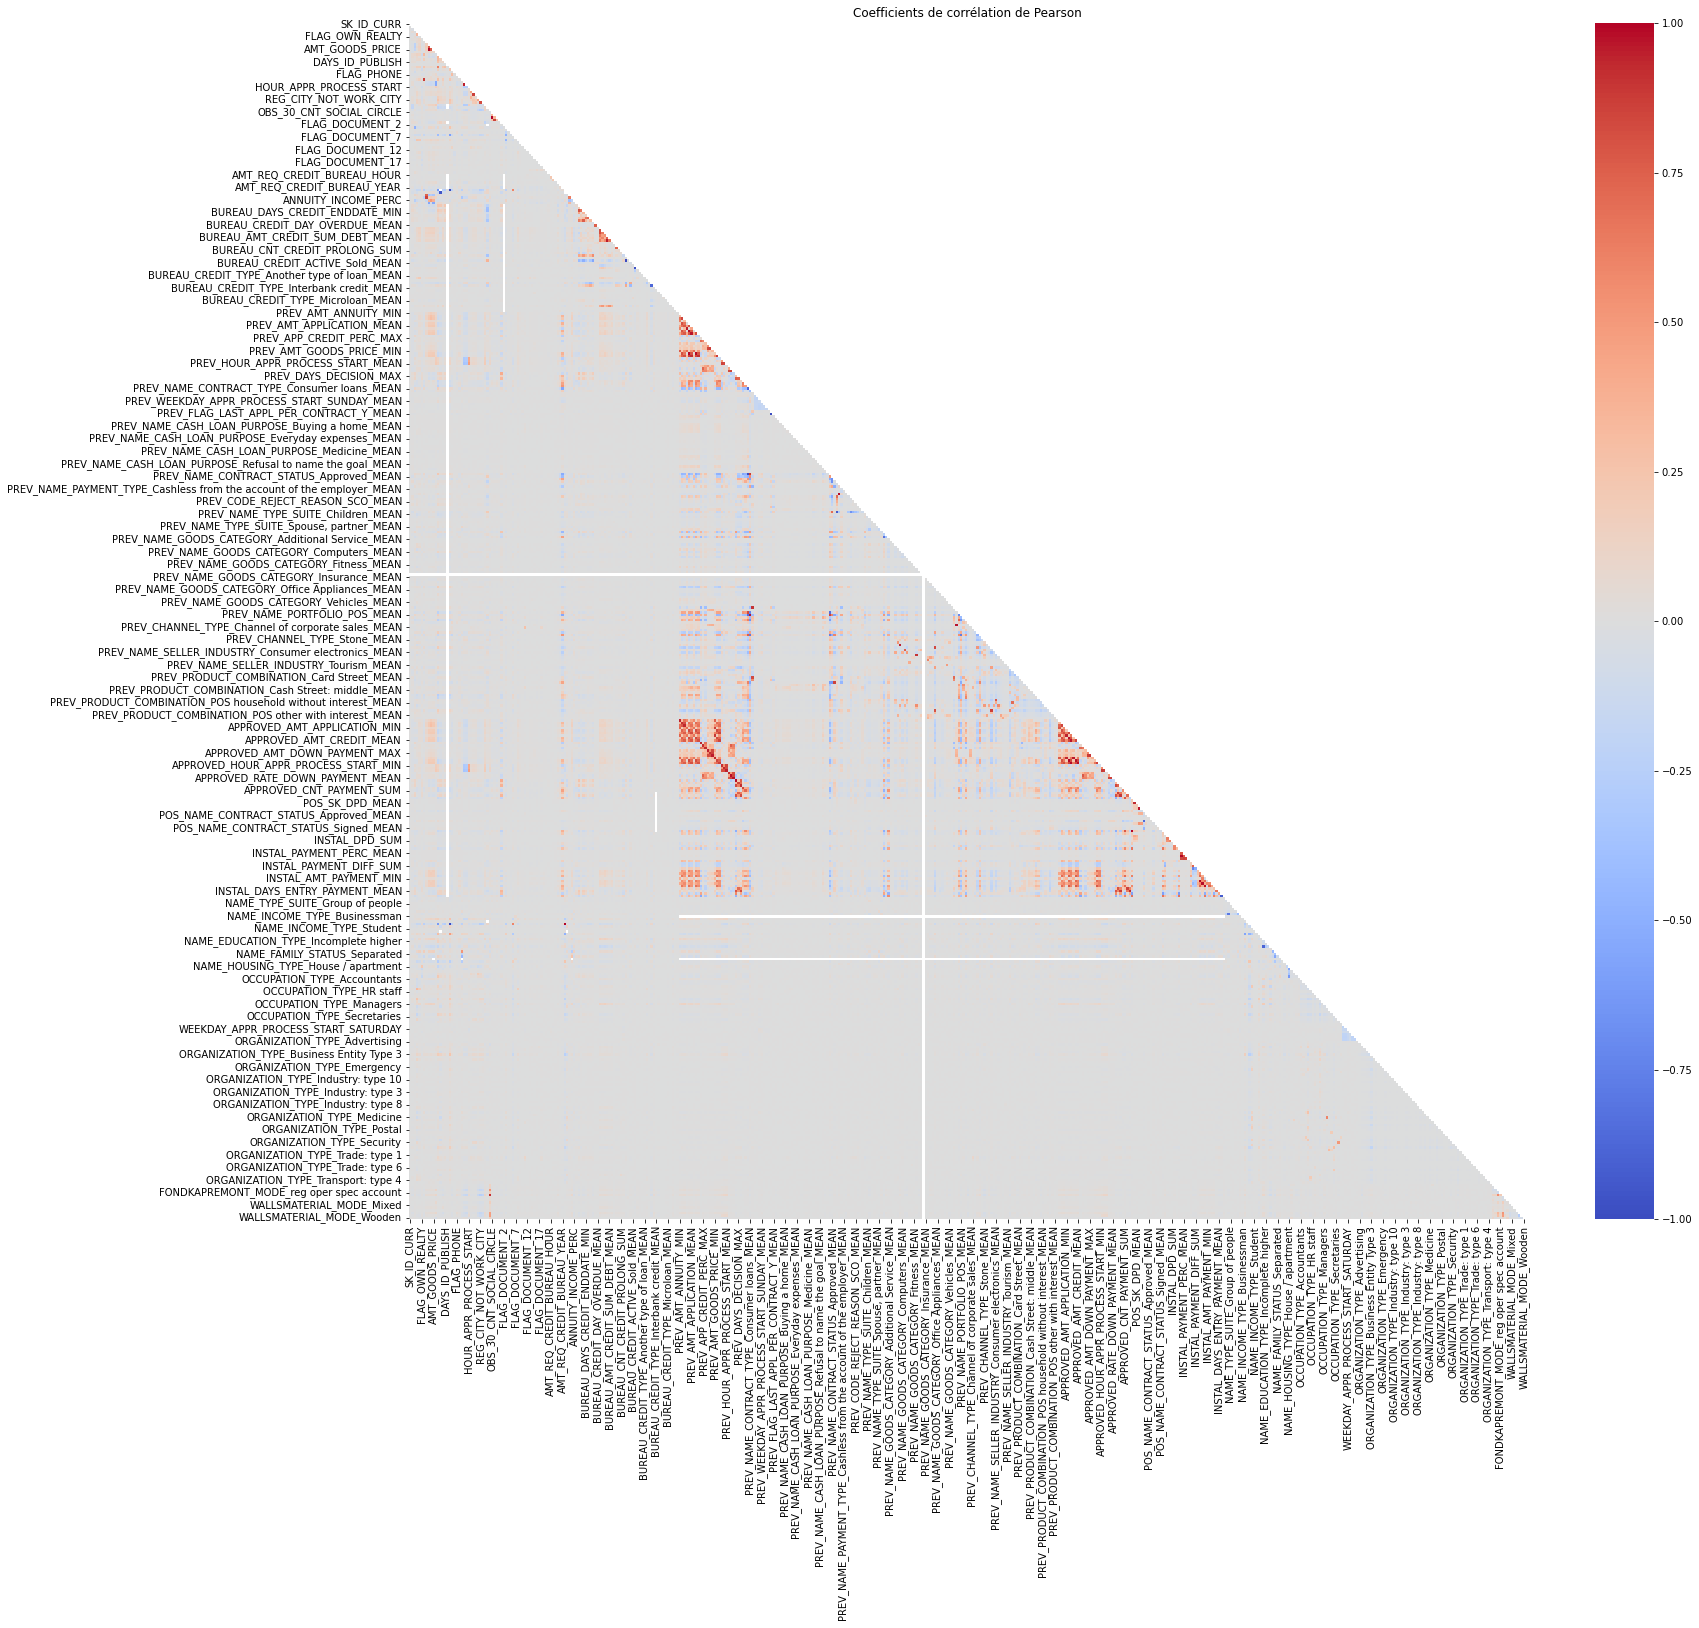

In [56]:
mask = np.triu(np.ones_like(corr, dtype=bool))

# graph
fig = plt.figure(figsize=(25, 22))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson")
plt.show()

In [57]:
# identification des paires n'ayant pas de coeff de correlation (NaN)
no_corr = corr.isna().unstack().reset_index()
no_corr.columns = ['feature_1', 'feature_2', 'non_correlees']
# selection des paires ayant un coeff de pearson à NaN
no_corr = no_corr[no_corr.non_correlees]
# no_corr.feature_2.value_counts()
# les features qui présentent autant de valeurs de NaN que le nb de features ne sont pas interessantes pour la suite
no_corr = no_corr.feature_2.value_counts()[no_corr.feature_2.value_counts() == data_final.shape[1]]
to_drop = list(no_corr.index)

# on garde forcement les variables AMT_Annuity, AMT_income_total et AMT_credit
for feature_to_keep in ['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']:
    if feature_to_keep in to_drop:
        to_drop.remove(feature_to_keep)

print("Il y a %d variables à supprimer" % len(to_drop))

Il y a 1 variables à supprimer


In [58]:
# corr_data: Matrice des corrélation avec NaN à la place des doublons
corr_data = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(bool))
# corr_data: Liste contenant les triplet (feature1, feature2, coefficient_corr)
corr_data = corr_data.unstack().reset_index()
corr_data.columns = ['feature_1', 'feature_2', 'pearson']
# On supprime les coefficients valant NaN (qui étaient des doublons)
corr_data.dropna(subset=['pearson'], inplace=True)
# On prend la valeur absolue arrondie à 3 chiffres des coefficients
corr_data['pearson'] = round(corr_data['pearson'], 3)
corr_data['pearson'] = abs(corr_data['pearson'])
corr_data = corr_data.sort_values(by='pearson', ascending=False)
corr_data

,feature_1,feature_2,pearson
31433,DAYS_EMPLOYED_ANOM,FLAG_EMP_PHONE,1.0
62475,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_APPLICATION_MAX,1.0
73934,PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN,1.0
170425,NAME_INCOME_TYPE_Pensioner,FLAG_EMP_PHONE,1.0
153104,POS_COUNT,POS_MONTHS_BALANCE_SIZE,1.0
...,...,...,...
188380,OCCUPATION_TYPE_Secretaries,NAME_INCOME_TYPE_Student,0.0
188377,OCCUPATION_TYPE_Secretaries,NAME_INCOME_TYPE_Maternity leave,0.0
188375,OCCUPATION_TYPE_Secretaries,NAME_INCOME_TYPE_Businessman,0.0
188368,OCCUPATION_TYPE_Secretaries,NAME_TYPE_SUITE_Children,0.0


<AxesSubplot:>

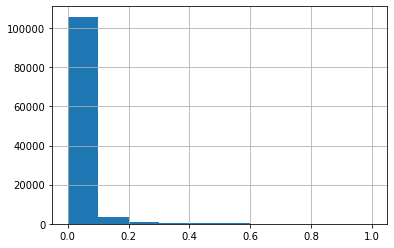

In [59]:
corr_data.pearson.hist()

In [60]:
# corr_min: Coefficient minimal pour considérer la corrélation comme forte
corr_min = 0.8
# corr_data_max: Va contenir les paire de variables fortement corrélées
corr_data_max = corr_data[corr_data['pearson'] >= corr_min]
print("Il y a %d corrélations fortes" % len(corr_data_max))


Il y a 170 corrélations fortes


pour chaque couple de variable fortement corrélé je garde la variable la plus corrélée à la cible

In [61]:
def lower_value(features, value):
    """Sélectionne la variable avec la value la plus faible entre deux variables."""
    feature1, feature2 = features.iloc[0], features.iloc[1]
    # print(feature1, feature2)
    # print(value[feature1], value[feature2])
    if value[feature1] > value[feature2]:
        aux = feature1
        feature1 = feature2
        feature2 = aux
    if feature1 in ['AMT_INCOME_TOTAL', 'AMT_ANNUITY']:
        aux = feature1
        feature1 = feature2
        feature2 = aux
    # print(feature1)
    return feature1

In [62]:
# corr_features: Va contenir la liste des variables à supprimer, car redondantes
# choix variable à supprimer = variable la moins corrélée à la cible
corr_features = corr_data_max[['feature_1', 'feature_2']]
corr_features = corr_features.apply(lower_value, args=(corr['TARGET'].map(abs),), axis=1)

print("cette liste regroupe {} variables qui seront supprimées".format(len(corr_features.unique())))


cette liste regroupe 92 variables qui seront supprimées


In [63]:
to_drop += list(corr_features.unique())

# on garde forcement les variables AMT_Annuity, AMT_income_total et AMT_credit
for feature_to_keep in ['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']:
    if feature_to_keep in to_drop:
        to_drop.remove(feature_to_keep)

print("Il y a %d variables à supprimer" % len(to_drop))

Il y a 92 variables à supprimer


In [64]:
# Suppression des variables listées dans to_drop
data_final = data_final.drop(columns=to_drop)
# mise à jour liste names_quali
names_quali = [feature for feature in names_quali if feature not in to_drop]
print("il reste {} variables categorielles".format(len(names_quali)))
data_final.shape

il reste 160 variables categorielles


(307507, 384)

## Variables insuffisamment corrélées à la target

In [65]:
corr2 = data_final.corr()

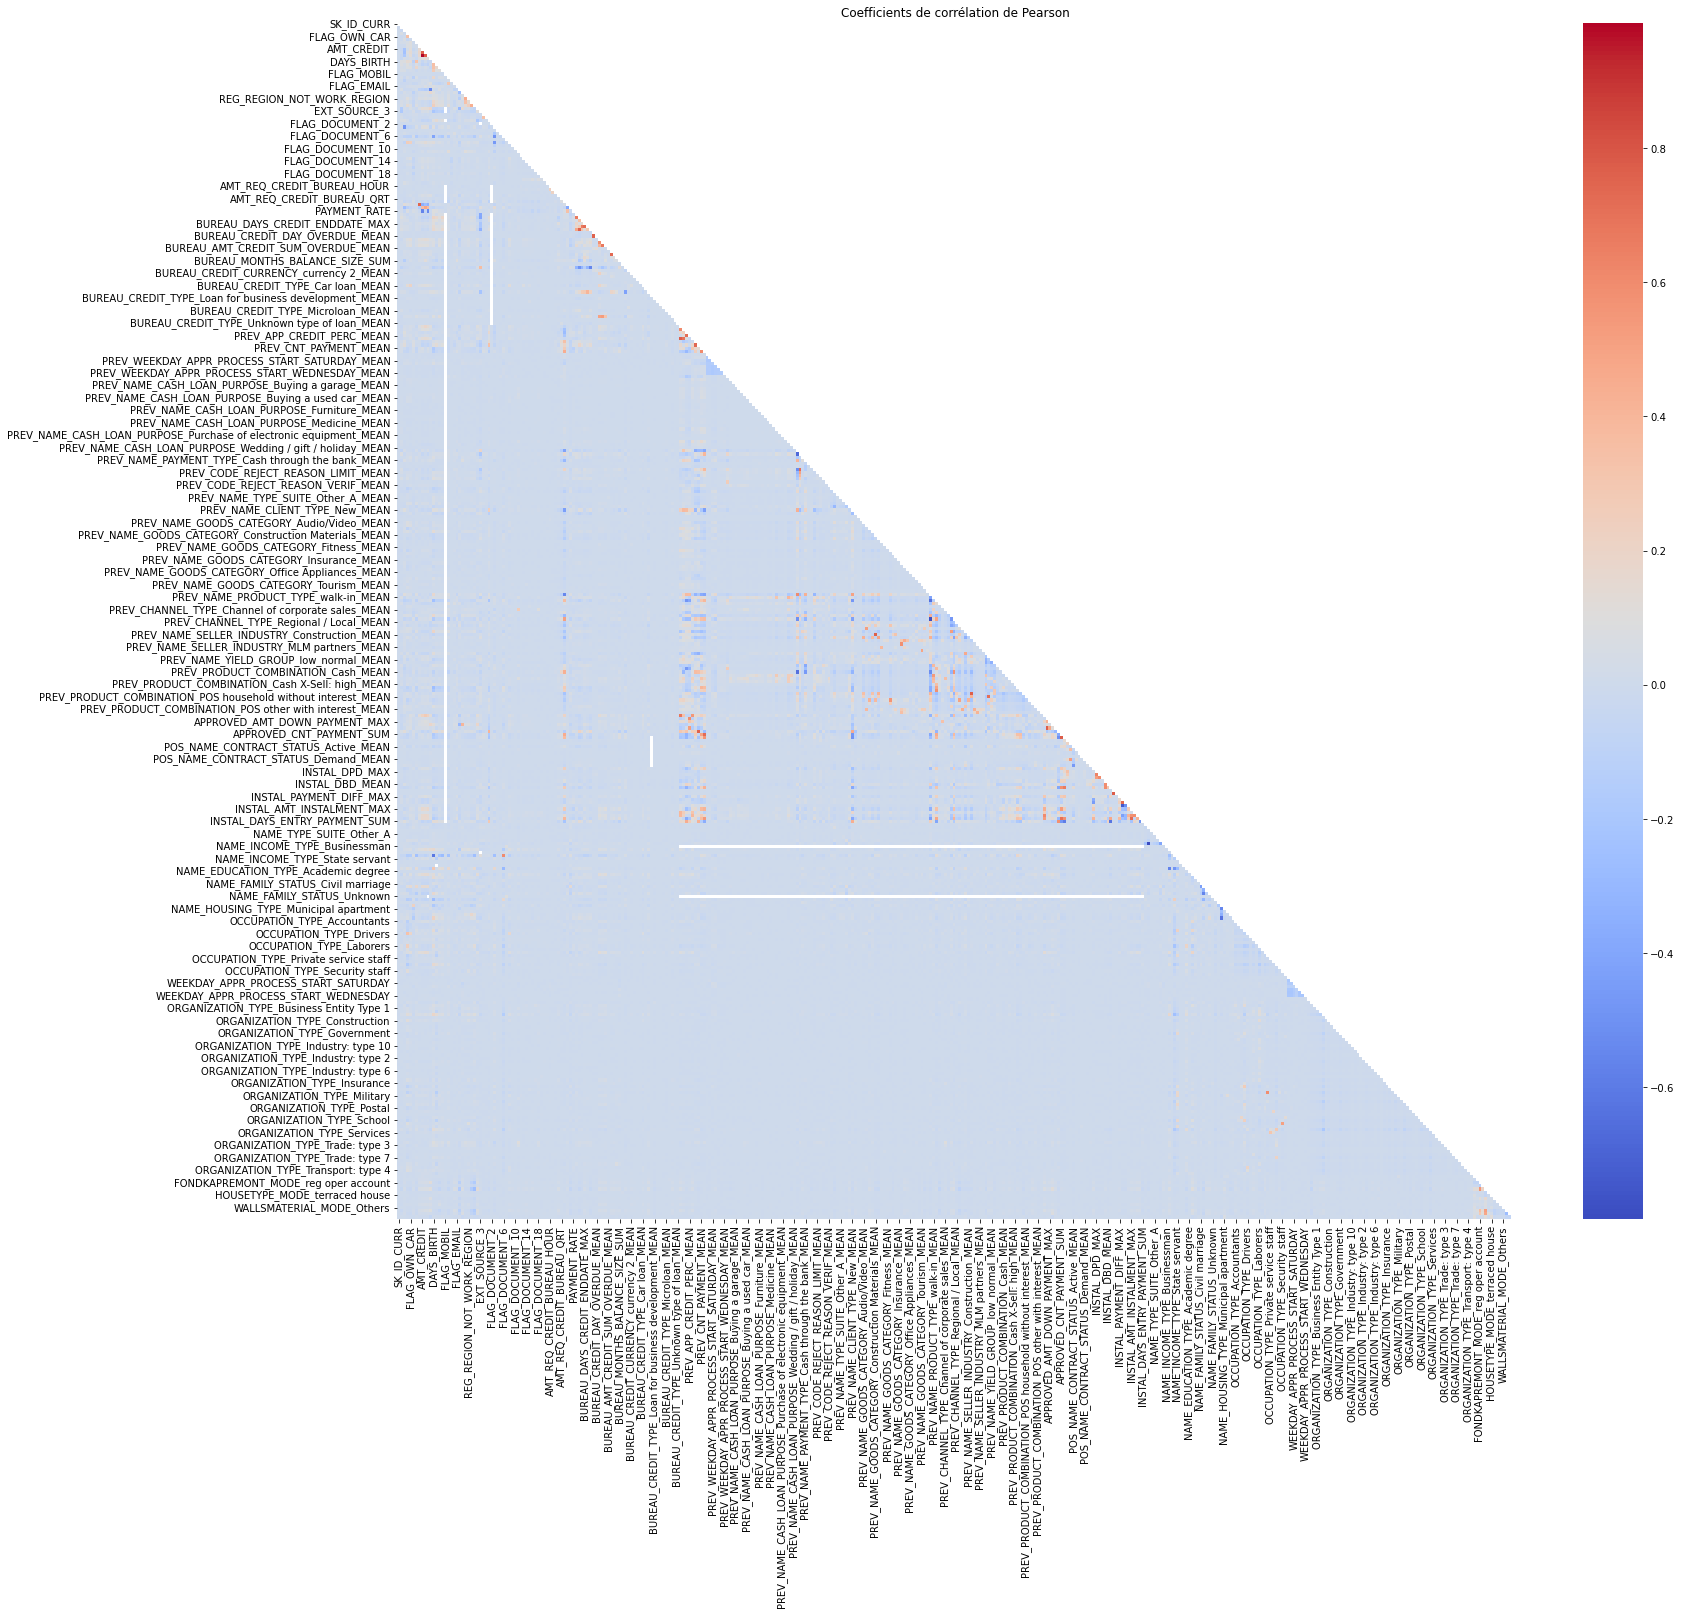

In [66]:
mask = np.triu(np.ones_like(corr2, dtype=bool))

# graph
fig = plt.figure(figsize=(25, 22))
sns.heatmap(data=corr2, mask=mask, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson")
plt.show()

In [67]:
# liste des correlations avec la target (en valeur absolue)
corr_target = corr2['TARGET'].abs().sort_values(ascending=False)
corr_target.dropna(inplace=True)
# selection des corrélations trop faibles
corr_target_faible = corr_target[corr_target < 0.01].index
print(len(corr_target_faible))
print("%d variables suffisamment corrélées à TARGET" % (len(data_final.columns)-len(corr_target_faible)))

225
159 variables suffisamment corrélées à TARGET


Les variables les plus corrélées à la target sont :

In [68]:
abs(corr_target.dropna()).sort_values(ascending=False).iloc[1:10]

EXT_SOURCE_3                               0.178926
EXT_SOURCE_2                               0.160471
BUREAU_DAYS_CREDIT_MEAN                    0.089731
BUREAU_CREDIT_ACTIVE_Closed_MEAN           0.079369
DAYS_BIRTH                                 0.078242
PREV_NAME_CONTRACT_STATUS_Refused_MEAN     0.077681
DAYS_EMPLOYED                              0.074957
BUREAU_DAYS_CREDIT_UPDATE_MEAN             0.068929
PREV_NAME_CONTRACT_STATUS_Approved_MEAN    0.063526
Name: TARGET, dtype: float64

In [69]:
to_drop = list(corr_target_faible.unique())

# on garde forcement les variables AMT_Annuity, AMT_income_total et AMT_credit
for feature_to_keep in ['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']:
    if feature_to_keep in to_drop:
        to_drop.remove(feature_to_keep)

print("Il y a %d variables à supprimer" % len(to_drop))

Il y a 224 variables à supprimer


In [70]:
# Suppression des variables listées dans to_drop
data_final = data_final.drop(columns=to_drop)
# mise à jour liste names_quali
names_quali = [feature for feature in names_quali if feature not in to_drop]
print("il reste {} variables categorielles".format(len(names_quali)))
data_final.shape

il reste 48 variables categorielles


(307507, 160)

## Outliers

In [71]:
# liste des features quantitatives
masque_quali = data_final.columns.isin(names_quali)
names_quanti = data_final.columns[~masque_quali]
print("il y a {} variables quantitatives".format(len(names_quanti)))

il y a 112 variables quantitatives


In [72]:
def drop_outliers_all(df, colonnes, nb_IQR):
    """
    suppression des lignes contenant des outliers selon une colonne
    """
    for col in colonnes:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3-Q1
        
        not_outlier = np.logical_and(Q1 - nb_IQR * IQR <= data[col], data[col] <= Q3 + nb_IQR * IQR)
        to_drop = ~(np.logical_or(not_outlier, data[col].isna()))
        if to_drop.sum() > 0:
            # print(col, ': suppression des {} valeurs inférieures à {}'.format(to_drop.sum(), (Q1 - nb_IQR * IQR)),
            #     'et supérieures à ', (Q3 + nb_IQR * IQR))
            df_final = df.drop(index=df.index[to_drop])
    return df_final


In [73]:
data_final = drop_outliers_all(data_final, names_quanti, nb_IQR=5)

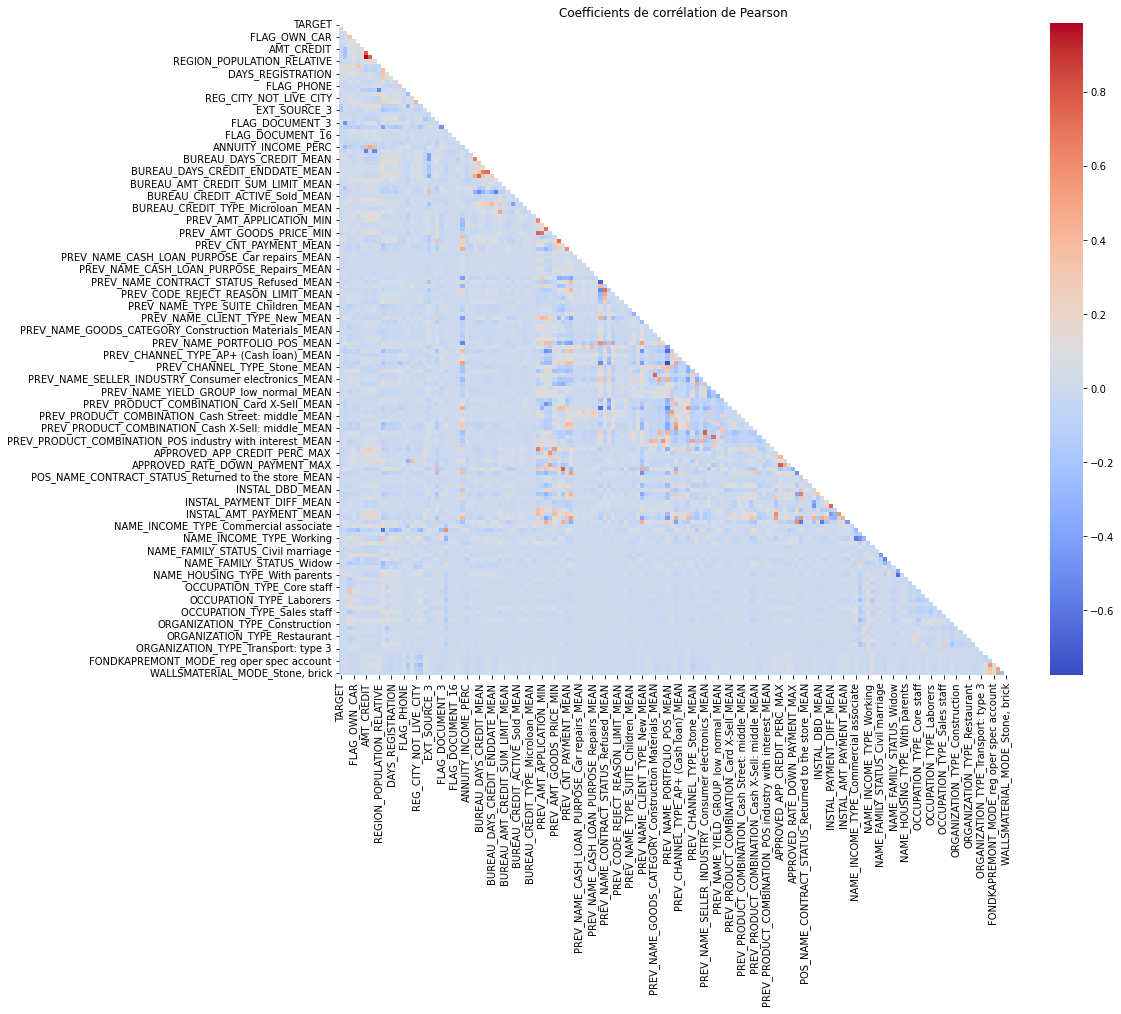

In [74]:
corr_final = data_final.corr()
# pour masquer la partie supérieure droite de la matrice de corrélation
mask = np.triu(np.ones_like(corr_final, dtype=bool))

# graph
fig = plt.figure(figsize=(15, 12))
sns.heatmap(data=corr_final, mask=mask, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson")
plt.show()

# Imputation
## Variables quantitatives : imputation par la moyenne

In [75]:
fct.pourcent_NA_df(data_final)

Il y a 95.53% valeurs renseignées (soit 4.47 % de valeurs manquantes) dans l'intégralité du df


In [76]:
fct.pourcent_NA_df(data_final[names_quanti])

Il y a 93.62% valeurs renseignées (soit 6.38 % de valeurs manquantes) dans l'intégralité du df


In [77]:
fct.taux_remplissage_colonne(data_final[names_quanti])

,index,taux remplissage
0,TARGET,100.000000
1,DAYS_BIRTH,100.000000
2,HOUR_APPR_PROCESS_START,100.000000
3,CNT_CHILDREN,100.000000
4,DAYS_ID_PUBLISH,100.000000
...,...,...
107,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,84.898609
108,BUREAU_DAYS_CREDIT_ENDDATE_MIN,84.898609
109,DAYS_EMPLOYED,82.035039
110,EXT_SOURCE_3,80.110996


In [78]:
# mean_imputer: Imputeur par la moyenne
mean_imputer = SimpleImputer(strategy='mean')
mean_imputer.fit(data_final[names_quanti])
# On impute les variables quantitatives
data_final.loc[:, names_quanti] = mean_imputer.transform(data_final[names_quanti])

## Variables qualitatives
imputation non nécessaire car j'ai déjà supprimé les colonnes correspondant aux valeurs NaN

In [79]:
fct.pourcent_NA_df(data_final)

Il y a 100.00% valeurs renseignées (soit 0.00 % de valeurs manquantes) dans l'intégralité du df


In [80]:
fct.pourcent_NA_df(data_final[names_quali])

Il y a 100.00% valeurs renseignées (soit 0.00 % de valeurs manquantes) dans l'intégralité du df


  # Export des données pour la modélisation

In [81]:
print("Finalement, on a une table d'entraînement de %d individus et %d variables" % (len(data_final), len(data_final.columns)))
data_final.to_csv('../01_DATA/data_for_modelling.csv')


Finalement, on a une table d'entraînement de 304515 individus et 160 variables
